In [1]:
# Basic imports, make sure they can import robustness
import torch as ch
from robustness.datasets import DATASETS
from robustness.tools.vis_tools import show_image_row
from robustness.tools import helpers
import torchvision.models as models
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np
import PIL

%matplotlib inline

In [2]:
BATCH_SIZE = 256
NUM_WORKERS = 10

In [3]:
test_set = DATASETS['imagenet']('/scratch/engstrom_scratch/imagenet')
_, val_loader = test_set.make_loaders(NUM_WORKERS, BATCH_SIZE)
normalization_function = helpers.InputNormalize(test_set.mean, test_set.std)

==> Preparing dataset imagenet..


In [4]:
model = models.resnet18(pretrained=True).cuda()
model.eval()
model = ch.nn.DataParallel(model)
pass

In [5]:
def forward_pass(im):
    im_norm = normalization_function(im)
    return model(im_norm.cuda())

In [6]:
if False:
    correct_cnt, total = 0, 0
    it = tqdm(enumerate(val_loader), total=len(val_loader))
    for itidx, (im, targ) in it:
        with ch.no_grad():
            op = forward_pass(im)
            pred = op.argmax(dim=1)
            correct = targ.cuda().eq(pred)

            correct_cnt += np.sum(correct.cpu().numpy())
            total += len(targ)
            it.set_description(f"Accuracy: {100 * correct_cnt/total:.2f}")

In [41]:
def get_gradient(im, targ):
    x = im.clone().detach().requires_grad_(True)
    op = forward_pass(x)
    loss = ch.nn.CrossEntropyLoss()(op, targ.cuda())
    grad, = ch.autograd.grad(loss, [x])
    return grad

def vis_tensor(t):
    mt = ch.mean(t, axis=[0, 2, 3])[None, :, None, None].expand_as(t)
    st = ch.std(t, axis=[0, 2, 3])[None, :, None, None].expand_as(t)
    return ch.clamp((t - mt) / (5 * st) + 0.5, 0, 1) 

def smooth_grad(im, targ, Nsamples, stdev=.3):
    total_gradients = 0
    for n in range(Nsamples):
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        grad = get_gradient(noised_im, targ)
        total_gradients += grad

    return total_gradients / Nsamples

In [8]:
_, (img, targ) = next(enumerate(val_loader))

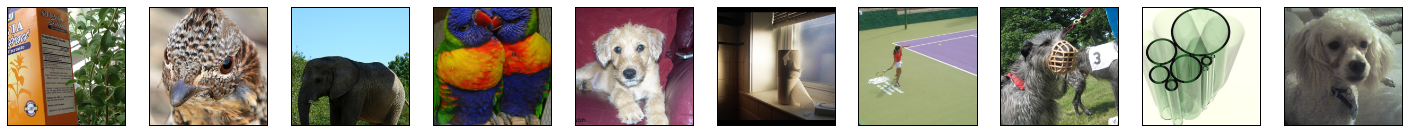

In [9]:
show_image_row([img[:10]])

In [36]:
grad = get_gradient(img, targ)
sgrad = smooth_grad(img, targ, 100)

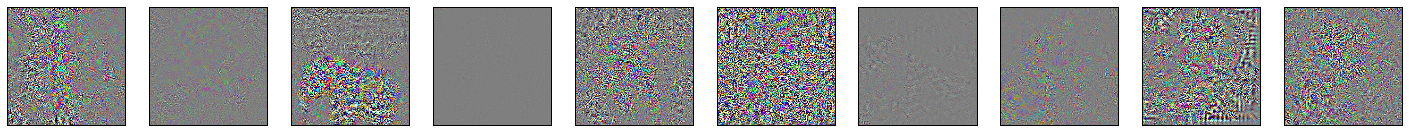

In [37]:
show_image_row([vis_tensor(grad)[:10]])

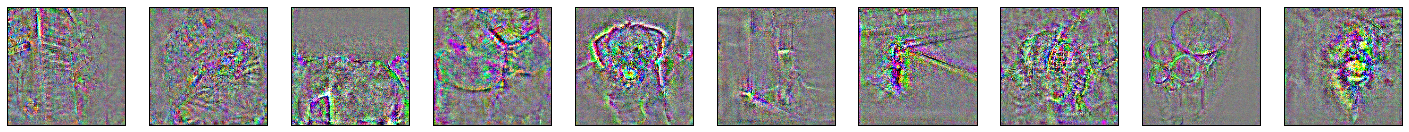

In [42]:
show_image_row([vis_tensor(sgrad)[:10]])